In [186]:
# apply the model to the sampled data
predictions_1 = export_model.predict(df_sample["comments"].astype(str).values)
predictions_1 = predictions.flatten()

df_sample["ml_sentiment_score"] = predictions_1
df_sample["ml_sentiment"] = (df_sample["ml_sentiment_score"] > 0.5).astype(int)

# print("Sample of prediction scores:")
# print(df_sample[["comments", "ml_sentiment_score", "ml_sentiment"]].head())

# # Verify the range of sentiment scores
# print("\nMin sentiment score:", df_sample["ml_sentiment_score"].min())
# print("Max sentiment score:", df_sample["ml_sentiment_score"].max())
# print("Distribution of sentiment scores:")
# print(pd.cut(df_sample["ml_sentiment_score"], bins=10).value_counts().sort_index())


In [187]:
# save the results
output_columns = ["listing_id", "id", "date", "reviewer_id", "reviewer_name", "comments", "sentiment_label", "ml_sentiment_score", "ml_sentiment"]
df_sample[output_columns].to_csv("classified_reviews_ml_1.csv", index=False)
print("Saved classified reviews to 'classified_reviews_ml_1.csv'")
print("Sample of the output:")
print(df_sample[output_columns].head())

In [152]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import pandas as pd
import re
from langdetect import detect
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [153]:
#load the dataset
print("loading airbnb reviews dataset...")
df = pd.read_csv("reviews.csv")
print(f"Orginal dataset\n {df}")

In [154]:
# Clean html tags
def clean_html(text):
    if isinstance(text, str):
        return re.sub(r"<.*?>", "", text)
    return text

In [155]:
# Remove the empty comments rows
df = df.dropna(subset=["comments"])
df["comments"] = df["comments"].apply(clean_html)
print(f"After remoing empty comments\n {df}")

In [156]:
# Filter out the rows that isn't in English
def is_english(text):
    try:
        return detect(text) == "en"
    except:
        return False
    
df["is_english"] = df["comments"].apply(is_english)
df = df[df["is_english"]]
print(f"After removing non-english comments\n {df}")

In [203]:
# create the model
print("Creating labels for training model...")
positive_words = ['great', 'good', 'nice', 'excellent', 'perfect', 'happy', 'wonderful', 
                 'fantastic', 'amazing', 'love', 'best', 'beautiful', 'clean', 'comfortable']
negative_words = ['bad', 'poor', 'terrible', 'horrible', 'awful', 'worst', 'dirty', 
                 'disappointing', 'disappointment', 'uncomfortable', 'problem', 'not clean', 'broken']

Creating labels for training model...


In [204]:
def simple_sentiment(text):
    if not isinstance(text, str):
        return 1
    
    text = text.lower()
    pos_count = sum(1 for word in positive_words if word in text)
    neg_count = sum(1 for word in negative_words if word in text)

    if neg_count > pos_count:
        return "NEGATIVE" 
    else:
        return "POSITIVE"

In [205]:
# create simple labels
df["sentiment_label"] = df["comments"].apply(simple_sentiment)

In [206]:
# Print distribution of initial labels
print("\nInitial sentiment distribution:")
label_counts = df["sentiment_label"].value_counts()
print(label_counts)
print(f"Positive percentage: {label_counts[1]/len(df)*100:.2f}%")


Initial sentiment distribution:
sentiment_label
POSITIVE    99257
NEGATIVE      448
Name: count, dtype: int64
Positive percentage: 0.45%


/tmp/ipykernel_943/2134060337.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"Positive percentage: {label_counts[1]/len(df)*100:.2f}%")


In [161]:
# # Create simple labels
# df["sentiment"] = df["comments"].apply(simple_sentiment)

# # Print sentiment inital distribution
# print("\nInitial Sentiment distribution:")
# label_counts = df["sentiment"].value_counts()
# print(label_counts)
# print(f"Positive percentage: {label_counts['POSITIVE']/len(df)*100:.2f}%")

In [207]:
#Convert sentiment labels to numeric values
df["sentiment_numeric"] = df["sentiment_label"].map({"POSITIVE": 1, "NEGATIVE": 0})

In [208]:
# Handle class imbalance
positive_samples = df[df["sentiment_numeric"] == 1]
negative_samples = df[df["sentiment_numeric"] == 0]

In [209]:
# get some number of positive samples as negative samples
positive_down_sampled = positive_samples.sample(n=len(negative_samples) * 3, random_state=42)
balanced_df = pd.concat([positive_down_sampled, negative_samples])

print(f"\nBalanced dataset shape: {balanced_df.shape}")
print("Balanced sentiment distribution:")
print(balanced_df['sentiment_label'].value_counts())


Balanced dataset shape: (1792, 9)
Balanced sentiment distribution:
sentiment_label
POSITIVE    1344
NEGATIVE     448
Name: count, dtype: int64


In [210]:
# split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(
    balanced_df["comments"],
    balanced_df["sentiment_numeric"],
    test_size=0.2,
    random_state=42
)

print(f"Training set size: {len(x_train)}")
print(f"Test set size: {len(x_test)}")

Training set size: 1433
Test set size: 359


In [211]:
#create a text vectorization layer
max_features = 10000
sequence_length = 250

vectorize_layer = tf.keras.layers.TextVectorization(
    standardize="lower_and_strip_punctuation",
    max_tokens=max_features,
    output_mode="int",
    output_sequence_length=sequence_length
)


In [212]:
vectorize_layer.adapt(x_train.values)

In [213]:
# build the model
embedding_dim = 16

model = tf.keras.Sequential([
    vectorize_layer,
    tf.keras.layers.Embedding(max_features + 1,embedding_dim),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

In [214]:
# compile the model
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    optimizer="adam",
    metrics=["accuracy"]
)
model.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization_7            │ ?                      │   0 (unbuilt) │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_10 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_8      │ ?                      │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [215]:
# Train the model
x_train = np.array(x_train)
y_train = np.array(y_train)
print(x_train.dtype, y_train.dtype)


history = model.fit(
    x_train,
    y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

object int64
Epoch 1/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7270 - loss: 0.5799 - val_accuracy: 0.7282 - val_loss: 0.5669
Epoch 2/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7734 - loss: 0.5022 - val_accuracy: 0.7282 - val_loss: 0.5566
Epoch 3/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7713 - loss: 0.4959 - val_accuracy: 0.7282 - val_loss: 0.5496
Epoch 4/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7586 - loss: 0.5191 - val_accuracy: 0.7282 - val_loss: 0.5476
Epoch 5/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7876 - loss: 0.4731 - val_accuracy: 0.7282 - val_loss: 0.5419
Epoch 6/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7604 - loss: 0.5016 - val_accuracy: 0.7352 - val_loss: 0.5438
Epoch 7/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7703 - loss: 0.5009 - val_accuracy: 0.7352 - val_loss: 0.5381
Epoch 8/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7622 - loss: 0.4994 - val_accuracy: 0.742

In [216]:
# eval model

x_test = np.array(x_test.tolist()) if isinstance(x_test, np.ndarray) else np.array(x_test)
y_test = np.array(y_test.tolist()) if isinstance(y_test, np.ndarray) else np.array(y_test)


loss, accuracy = model.evaluate(x_test, y_test)
print(f"Test accuracy: {accuracy:.4f}")

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7471 - loss: 0.5176 
Test accuracy: 0.7465


In [217]:
# predict and analyse
predictions = model.predict(x_test)
binary_predictions = (predictions > 0.5).astype(int)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


In [218]:
# print classification report
print("Classification report:")
print(classification_report(y_test, binary_predictions))

Classification report:
              precision    recall  f1-score   support

           0       0.89      0.08      0.15        98
           1       0.74      1.00      0.85       261

    accuracy                           0.75       359
   macro avg       0.82      0.54      0.50       359
weighted avg       0.78      0.75      0.66       359



Saved training history to 'training_history.png'


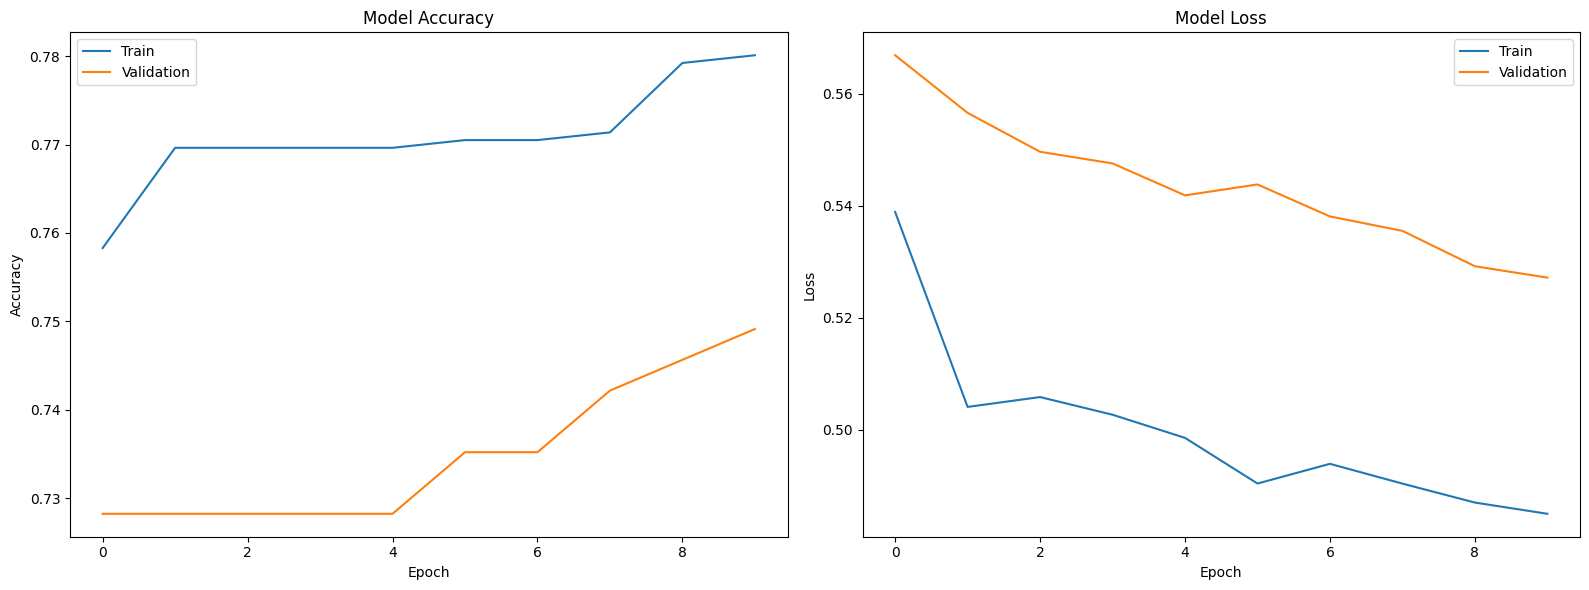

In [219]:
# 10. VISUALIZE TRAINING HISTORY
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])

plt.tight_layout()
plt.savefig('training_history.png')
print("Saved training history to 'training_history.png'")

In [220]:
# save the model
model.save("airbnb_sentiment_model.keras")
print("Model saved to 'airbnb_sentiment_model'")

Model saved to 'airbnb_sentiment_model'


In [221]:
# apply model to full dataset
export_model = tf.keras.Sequential([
    vectorize_layer,
    model.layers[1],
    model.layers[2],
    model.layers[3],
    model.layers[4],
    model.layers[5]
])

In [222]:
# sample the data if its to large
sample_size = min(10000, len(df))
df_sample = df.sample(n=sample_size, random_state=42)

In [223]:
# Apply the model to the sampled data
df_sample['ml_sentiment_score'] = export_model.predict(df_sample['comments'].astype(str).values)
df_sample['ml_sentiment'] = (df_sample['ml_sentiment_score'] > 0.5).astype(int)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [226]:
df_sample["ml_sentiment_label"] = df_sample["ml_sentiment"].map({1: "POSITIVE", 0: "NEGATIVE"})
output_columns = ["listing_id", "id", "date", "reviewer_id", "reviewer_name", "comments", "ml_sentiment_score", "ml_sentiment_label"]
df_sample[output_columns].to_csv("classified_reviews_ml_1.csv", index=False)

print("\nSaved classified reviews to 'classified_reviews_ml_1.csv'")
print("Sample of the output:")
print(df_sample[output_columns].head())


Saved classified reviews to 'classified_reviews_ml_1.csv'
Sample of the output:
       listing_id                   id        date  reviewer_id reviewer_name  \
89748    46752010   896955831442471766  2023-05-22    402926410          Anne   
58756    30553531  1001332949177022015  2023-10-13     32050830      Jennifer   
1098       299154             21769773  2014-10-23     22280153        Tereza   
81886    40459957  1128900631296386641  2024-04-06    124388740      Clarence   
58309    30251993  1207175884646315540  2024-07-23     67989108       Gabriel   

                                                comments  ml_sentiment_score  \
89748  This place is great - awesome location. As the...            0.814731   
58756  The place is very clean and accessible, and th...            0.845077   
1098   Daniels apartment is in very nice neiborhood w...            0.817167   
81886   great place, great location and amazing service!            0.858023   
58309  There were a few problems